FAÇA UPLOAD DO SEU sao_paulo_nodes.csv


Saving sao_paulo_nodes.csv to sao_paulo_nodes.csv
CSV carregado: sao_paulo_nodes.csv
Depot: Matriz | Locations: 19
INICIANDO TREINAMENTO DQN...
Ep 0 | Reward: -1822.2 | Steps: 29 | ε: 1.000
Ep 100 | Reward: -1411.6 | Steps: 100 | ε: 0.010
Ep 200 | Reward: -1181.6 | Steps: 100 | ε: 0.010
Ep 300 | Reward: -1067.2 | Steps: 100 | ε: 0.010
Ep 400 | Reward: -1442.6 | Steps: 100 | ε: 0.010
Ep 500 | Reward: -1543.6 | Steps: 100 | ε: 0.010
Ep 600 | Reward: -2837.9 | Steps: 100 | ε: 0.010
Ep 700 | Reward: -1541.1 | Steps: 100 | ε: 0.010
Ep 800 | Reward: -1711.0 | Steps: 100 | ε: 0.010
Ep 900 | Reward: -1361.2 | Steps: 100 | ε: 0.010
DQN TREINADO E SALVO: dqn_model.pt


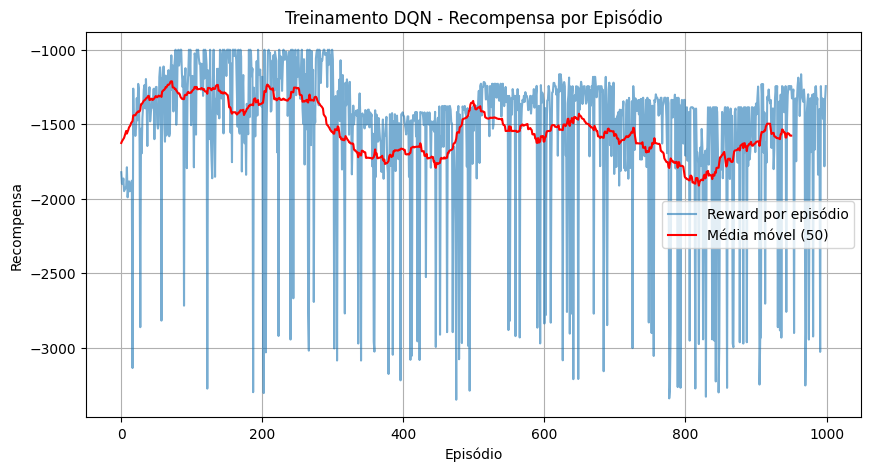

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

BAIXE dqn_model.pt E COLOQUE NO SEU PROJETO!


In [1]:
# =============================================
# DQN PARA SUPPLY CHAIN - TUDO EM UMA CÉLULA
# =============================================

!pip install geopy folium gradio torch numpy pandas matplotlib -q

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from typing import List, Dict, Tuple
from geopy.distance import geodesic
import os
import matplotlib.pyplot as plt

# -------------------------------
# 1. UPLOAD DO CSV
# -------------------------------
from google.colab import files
print("FAÇA UPLOAD DO SEU sao_paulo_nodes.csv")
uploaded = files.upload()
CSV_PATH = list(uploaded.keys())[0]
print(f"CSV carregado: {CSV_PATH}")

# -------------------------------
# 2. ENVIRONMENT (SupplyChainEnv)
# -------------------------------
class SupplyChainEnv:
    def __init__(self, locations: List[Dict], depot: Dict, max_steps: int = 100):
        self.locations = locations
        self.original_demands = np.array([loc['demand'] for loc in locations])
        self.depot = depot
        self.n_locations = len(locations)
        self.action_space = self.n_locations + 1  # +1 para voltar ao depot
        self.max_steps = max_steps
        self.reset()

    def reset(self):
        self.current_pos = self.depot
        self.current_idx = -1
        self.remaining_demand = self.original_demands.copy()
        self.steps = 0
        self.done = False
        self.route_positions = [self.depot]
        return self._get_state()

    def _get_state(self):
        return np.array([self.current_idx] + list(self.remaining_demand))

    def _valid_actions(self):
        pending = [i for i in range(self.n_locations) if self.remaining_demand[i] > 0]
        return pending + [self.n_locations]  # sempre pode voltar

    def _haversine(self, loc1, loc2):
        return geodesic((loc1['lat'], loc1['lon']), (loc2['lat'], loc2['lon'])).km

    def step(self, action):
        self.steps += 1
        reward = 0
        done = False
        info = {}

        prev_pos = self.current_pos.copy()

        if action == self.n_locations:  # volta ao depot
            dist = self._haversine(prev_pos, self.depot)
            self.current_pos = self.depot
            self.current_idx = -1
            self.route_positions.append(self.depot)
            reward = -dist * 1.5
            if all(self.remaining_demand <= 0):
                reward += 500
                done = True
        else:
            if self.remaining_demand[action] <= 0:
                reward = -100
            else:
                dist = self._haversine(self.current_pos, self.locations[action])
                demand = self.original_demands[action]
                cost = dist * 1.5 + demand * 0.8
                reward = -cost
                self.remaining_demand[action] = 0
                self.current_pos = self.locations[action]
                self.current_idx = action
                self.route_positions.append(self.locations[action])
                info['delivery'] = True

        if self.steps >= self.max_steps:
            reward -= 1000
            done = True

        self.done = done
        return self._get_state(), reward, done, info

# -------------------------------
# 3. DQN AGENT
# -------------------------------
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, action_size)
        )
    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.99
        self.batch_size = 64
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)

    def act(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state).cpu().detach().numpy()[0]
        valid_q = {a: q_values[a] for a in valid_actions}
        return max(valid_q, key=valid_q.get)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size: return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        current_q = self.q_network(states).gather(1, actions.unsqueeze(1))
        next_q = self.target_network(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = nn.MSELoss()(current_q.squeeze(), target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def save(self, path):
        torch.save(self.q_network.state_dict(), path)

# -------------------------------
# 4. CARREGA CSV E PREPARA DADOS
# -------------------------------
df = pd.read_csv(CSV_PATH)
depot = df.iloc[0].to_dict()
depot['demand'] = 0
locations = df.iloc[1:].to_dict('records')

print(f"Depot: {depot['name']} | Locations: {len(locations)}")

# -------------------------------
# 5. TREINAMENTO DQN
# -------------------------------
env = SupplyChainEnv(locations, depot, max_steps=100)
state_size = 1 + len(locations)
action_size = env.action_space

agent = DQNAgent(state_size, action_size)
episodes = 1000
rewards_log = []

print("INICIANDO TREINAMENTO DQN...")

for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    steps = 0

    while not env.done and steps < 100:
        valid = env._valid_actions()
        action = agent.act(state, valid)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.replay()
        state = next_state
        total_reward += reward
        steps += 1

    if ep % 100 == 0:
        agent.update_target()

    rewards_log.append(total_reward)

    if ep % 100 == 0:
        print(f"Ep {ep} | Reward: {total_reward:.1f} | Steps: {steps} | ε: {agent.epsilon:.3f}")

# -------------------------------
# 6. SALVA MODELO + GRÁFICO
# -------------------------------
agent.save("dqn_model.pt")
print("DQN TREINADO E SALVO: dqn_model.pt")

# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(rewards_log, alpha=0.6, label='Reward por episódio')
plt.plot(np.convolve(rewards_log, np.ones(50)/50, mode='valid'), label='Média móvel (50)', color='red')
plt.title("Treinamento DQN - Recompensa por Episódio")
plt.xlabel("Episódio")
plt.ylabel("Recompensa")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 7. DOWNLOAD DO MODELO
# -------------------------------
from google.colab import files
files.download("dqn_model.pt")
print("BAIXE dqn_model.pt E COLOQUE NO SEU PROJETO!")